In [20]:
import pandas as pd
import numpy as np
import matplotlib as plt
import time
import statsmodels.api as sm
import itertools
from dateutil import parser
from datetime import datetime, timedelta
%pylab inline

import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


Data Pre Processing

In [2]:
#Read in raw data

file_names = ['incidentsQ1','incidentsQ2','incidentsQ3','incidentsQ4']
keep_vars = ['incidentid','callstart','lat_incident','lon_incident','ccgcluster','chiefcomplaint','totaljobcycletime','dohcategory']
incidents = pd.DataFrame(columns=keep_vars)

for i in file_names:
    globals()[str(i)] = pd.read_csv("CUSP London Data Dive 2019/data/Incidents/"+i+".csv", parse_dates=['callstart'])[keep_vars]
    incidents = incidents.append(globals()[str(i)])
    
incidents = incidents.sort_values(by=['callstart'])
incidents = incidents.set_index('callstart')
incidents = incidents.loc[incidents.index >= '2018-01-01 00:00:00']
incidents = incidents.loc[incidents.index < '2019-01-01 00:00:00']

In [3]:
#Function to create time series

def output_timeseries(space):
    incidents_spatial = incidents[incidents['ccgcluster'] == space]
    call_response = incidents_spatial[['totaljobcycletime','dohcategory']].groupby([pd.Grouper(freq='240Min'),'dohcategory']).mean()
    call_freq = incidents_spatial[['incidentid','dohcategory']].groupby([pd.Grouper(freq='240Min'),'dohcategory']).count()
    call_freq['Call Frequency'] = 14400 / call_freq['incidentid']

    incidents_with_metrics = call_response.merge(call_freq, left_index = True, right_index = True)
    incidents_with_metrics['Demand Index'] = incidents_with_metrics['totaljobcycletime'] / incidents_with_metrics['Call Frequency']
    incidents_with_metricsReset = incidents_with_metrics.reset_index()
    columnValues = ['Demand Index']
    incident_time_series = incidents_with_metricsReset.pivot(index='callstart', columns='dohcategory', values=columnValues).fillna(0)
    return incident_time_series

In [4]:
#Split out spatially

space_clusters = ['North Central','North East','North West','South East','South West']

var_names = []
for i in space_clusters:
    globals()[str(i.replace(" ", ""))] = output_timeseries(i)
    var_names.append(i.replace(" ", ""))

In [ ]:
#Week on week plot

# row_count = 0
# week_count = 0
# c1_print = []
# fig = plt.figure(figsize=(15,10))


# for index, row in NorthCentral.iterrows():
#     c1_print.append(row['Demand Index']['C1 '])
#     row_count = row_count + 1
#     if row_count == 42:
#         row_count = 0
#         week_count = week_count +1
#         plt.plot(c1_print)
#         c1_print = []
#     if week_count == 5:
#         break

Develop Predictive Model

In [5]:
from statsmodels.tsa.stattools import acf, pacf
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [31]:
#Get Data for Jan - C1 - North Central
s = NorthCentral['Demand Index']['C1 ']
s = s.loc[s.index >= '2018-02-01 00:00:00']
s = s.loc[s.index < '2018-05-01 00:00:00']

In [32]:
# q_00 = s.iloc[::6]
# q_04 = s.iloc[1::6]
# q_08 = s.iloc[2::6]
q = s

(534,)


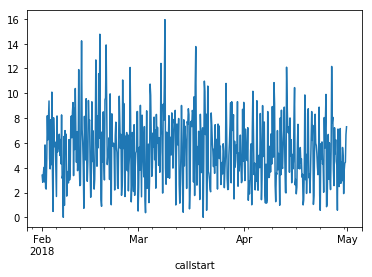

In [33]:
print(q.shape)
q.plot()

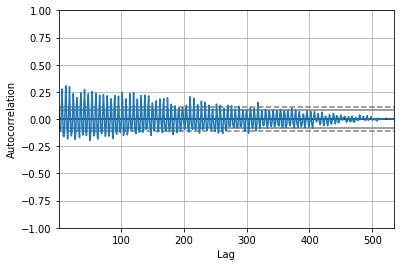

In [34]:
autocorrelation_plot(q)

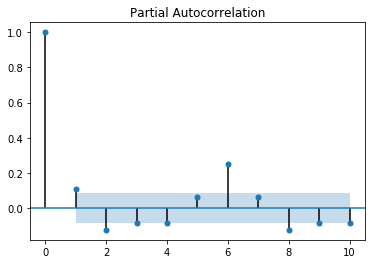

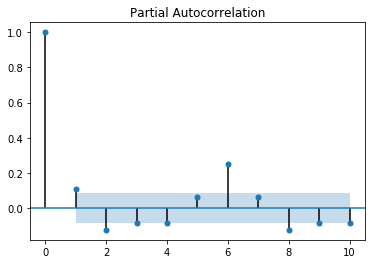

In [35]:
plot_pacf(q, lags=10)

In [ ]:
model = ARIMA(q, order=(2,0,1))
fit = model.fit()
print(fit.summary())
resids = pd.DataFrame(fit.resid)
resids.plot()

In [ ]:
resids.plot(kind='KDE')

In [ ]:
predictions.append(yhat)
obs = test[t]
history.append(obs)
print('predicted=%f, expected=%f' % (yhat, obs))

In [6]:
#Get All Data

def get_data(spacial,severity,date_start,date_end):
    s = spacial['Demand Index'][severity]
    s = s.loc[s.index >= date_start]
    s = s.loc[s.index < date_end]
    return s

In [7]:
train_start = '2018-01-01 00:00:00'
dt_t_start = parser.parse(train_start)

train_start = '2018-04-01 00:00:00'
dt_t_end = parser.parse(train_start)

pred_end = '2018-04-01 04:00:00'
pred_t_end = parser.parse(pred_end)

q = get_data(NorthCentral,'C1 ',dt_t_start,dt_t_end)

actual = get_data(NorthCentral,'C1 ',dt_t_end,pred_t_end)

In [36]:
def train_model(space,severity):
    predicted = []
    actuals = []

    train_start = '2018-01-01 00:00:00'
    dt_t_start = parser.parse(train_start)

    train_start = '2018-04-01 00:00:00'
    dt_t_end = parser.parse(train_start)

    pred_end = '2018-04-01 04:00:00'
    pred_t_end = parser.parse(pred_end)

    for i in range(0,180):
        #Get First Two Months
        q = get_data(space,severity,dt_t_start,dt_t_end)

        #Get predicted value
        actual = get_data(space,severity,dt_t_end,pred_t_end)

        #Append Actuals
        actuals.append(actual[0])

        #Fit Model
        model = ARIMA(q, order=(2,0,6))
        fit = model.fit()
        #Forecast
        output = fit.forecast()
        pred = output[0]
        #Append Predicted Value
        predicted.append(pred[0])

        dt_t_start = dt_t_start + timedelta(hours=4)
        dt_t_end = dt_t_end + timedelta(hours=4)
        pred_t_end = pred_t_end + timedelta(hours=4)
    
    return predicted, actuals

North East

In [ ]:
#North East C1

#Predict
NE_C1_pred, NE_C1_actuals = train_model(NorthEast,'C1 ')

#Print
actual_log = np.log(NE_C1_actuals)+5.5
plt.plot(actual_log)
plt.plot(NE_C1_pred)

In [ ]:
#North East C2

#Predict
NE_C2_pred, NE_C2_actuals = train_model(NorthEast,'C2 ')

#Print
plt.plot(NE_C2_actuals)
plt.plot(NE_C2_pred)

In [ ]:
#North East C3

#Predict
NE_C3_pred, NE_C3_actuals = train_model(NorthEast,'C3 ')

#Print
actual_log = np.log(NE_C3_actuals)
predicted_log = np.log(NE_C3_pred)
plt.plot(actual_log)
plt.plot(predicted_log)

In [ ]:
#North East C4

#Predict
NE_C4_pred, NE_C4_actuals = train_model(NorthEast,'C4 ')

#Print
plt.plot(NE_C4_actuals)
plt.plot(NE_C4_pred)

South East

In [ ]:
#South East C1

#Predict
SE_C1_pred, SE_C1_actuals = train_model(SouthEast,'C1 ')

#Print
actual_log = np.log(SE_C1_actuals)+5.5
plt.plot(actual_log)
plt.plot(SE_C1_pred)

In [ ]:
#South East C2

#Predict
SE_C2_pred, SE_C2_actuals = train_model(SouthEast,'C2 ')

#Print
plt.plot(SE_C2_actuals)
plt.plot(SE_C2_pred)

In [ ]:
#South East C3

#Predict
SE_C3_pred, SE_C3_actuals = train_model(SouthEast,'C3 ')

#Print
actual_log = np.log(SE_C3_actuals)
predicted_log = np.log(SE_C3_pred)
plt.plot(actual_log)
plt.plot(predicted_log)

In [ ]:
#South East C4

#Predict
SE_C4_pred, SE_C4_actuals = train_model(SouthEast,'C4 ')

#Print
plt.plot(SE_C4_actuals)
plt.plot(SE_C4_pred)

North Central

In [37]:
#North Central C1

#Predict
NC_C1_pred, NC_C1_actuals = train_model(NorthCentral,'C1 ')

#Print
actual_log = np.log(NC_C1_actuals)+4
plt.plot(actual_log)
plt.plot(NC_C1_pred)

rmse = np.sqrt(mean_squared_error(actual_log, NC_C1_pred))
print(rmse)

LinAlgError: SVD did not converge

In [ ]:
#Print
actual_log = np.log(NC_C1_actuals)+4
plt.plot(actual_log)
plt.plot(NC_C1_pred)

rmse = np.sqrt(mean_squared_error(actual_log, NC_C1_pred))
print(rmse)

In [ ]:
#North Central C2

#Predict
NC_C2_pred, NC_C2_actuals = train_model(NorthCentral,'C2 ')

#Print
plt.plot(NC_C2_actuals)
plt.plot(NC_C2_pred)

In [ ]:
#North Central C3

#Predict
NC_C3_pred, NC_C3_actuals = train_model(NorthCentral,'C3 ')

#Print
actual_log = np.log(NC_C3_actuals)
predicted_log = np.log(NC_C3_pred)
plt.plot(actual_log)
plt.plot(predicted_log)

In [ ]:
#North Central C4

#Predict
NC_C4_pred, NC_C4_actuals = train_model(NorthCentral,'C4 ')

#Print
plt.plot(NC_C4_actuals)
plt.plot(NC_C4_pred)